In [17]:
import shap
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from seaborn import kdeplot
from pickle import dump, load
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric_posvel, get_body, get_moon
import warnings; warnings.simplefilter('ignore')

In [24]:
def to_numpy(c, un):
    return np.array([c.x*un, c.y*un, c.z*un])

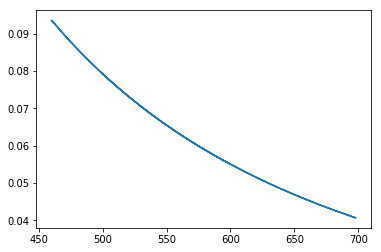

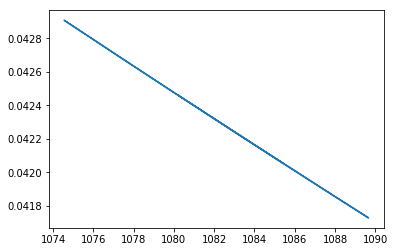

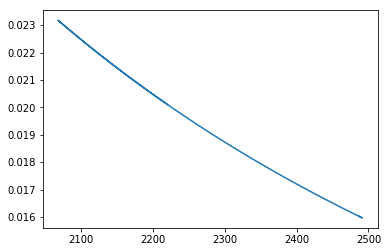

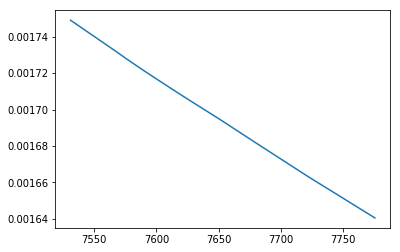

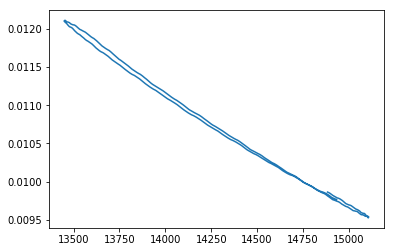

In [32]:
#Use the JPL Library to generate data

planets = ['mercury', 'venus', 'mars', 'jupiter', 'saturn']
days = {
    'mercury':100,
    'venus':250,
    'mars':500,
    'jupiter':500,
    'saturn':11000,
}
samples = 5000

LOAD = False

START_TIME = 2287185
SCALE = 10**(-5)


X = dict()
y = dict()

if LOAD:
    X = load(open("X.bin", "rb"))
    y = load(open("y.bin", "rb"))
    
else:
    for planet in planets:
        t = Time(START_TIME + np.linspace(0,days[planet],samples), format='jd')
        with solar_system_ephemeris.set('jpl'):
            plnt = get_body_barycentric_posvel(planet, t)
            sun = get_body_barycentric_posvel('sun', t)
        r = sun[0]-plnt[0]
        rv = sun[1]-plnt[1]
        pos = np.array([to_numpy(r[i], 1/u.km) for i in range(len(r))])*SCALE
        vel = np.array([to_numpy(rv[i], u.d/u.km) for i in range(len(rv))])*SCALE

        X[planet] = pd.DataFrame({
            "Dist_Sun": np.linalg.norm(pos, axis=1)[:-1]
        })
        y[planet] = pd.DataFrame({"Second Difference":np.linalg.norm(vel[1:] - vel[:-1], axis=1)})
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(X[planet], y[planet])

dump(X, open("X.bin", "wb"))
dump(y, open("y.bin", "wb"))

In [5]:
#Run randomized hyperparameter search for each of the training targets
plt.clf()

LOAD = True

if LOAD:
    params = load(open("params.bin" , "rb"))
    
else:
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    params = dict()
    for planet in planets:
        rf = RandomForestRegressor()
        rf_random = RandomizedSearchCV(estimator = rf, 
                                       param_distributions = random_grid, 
                                       n_iter = 100, cv = 3, 
                                       verbose=2, 
                                       random_state=1, 
                                       n_jobs = -1)
        rf_random.fit(X[planet],y[planet])
        params[planet] = rf_random.best_params_
        print("Best parameters for "+planet+":")
        pprint(params[planet])
        print()

dump(params, open("params.bin", "wb")) #pickle best parameters

<Figure size 432x288 with 0 Axes>

Error for mercury:
Bias: -5.887449509563375
Variance: 826446.2180192817
SSE 826480.8800810094

Error for venus:
Bias: -2.3599919999536367
Variance: 30348.724385027203
SSE 30354.293947267048

Error for mars:
Bias: -1.4993759348977507
Variance: 97931.16523272364
SSE 97933.41336091778

Error for jupiter:
Bias: -8.359472122035775
Variance: 563964.9327466789
SSE 564034.813520838

Error for saturn:
Bias: 15.419720257602338
Variance: 1677484.3708358917
SSE 1677722.1386087143

Error for uranus:
Bias: 51.669016657652406
Variance: 5738822.571489154
SSE 5741492.258771523



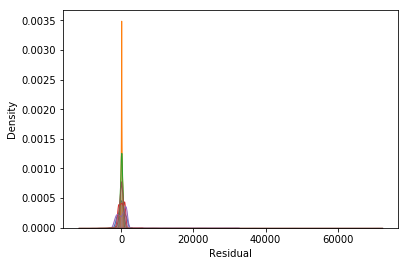

In [6]:
#Evaluate model performance on a validation dataset

residuals = dict()
rfs = dict()

ax = None

for planet in planets:
    pparams = params[planet]
    rf = RandomForestRegressor(n_estimators=pparams["n_estimators"], 
                                            min_samples_split = pparams["min_samples_split"], 
                                            min_samples_leaf = pparams["min_samples_leaf"], 
                                            max_features = pparams["max_features"], 
                                            max_depth = pparams["max_depth"], 
                                            bootstrap = pparams["bootstrap"])
    X_train, X_test, y_train, y_test = train_test_split(X[planet], y[planet]) 
    rf.fit(X_train, y_train)
    
    res = y_test.to_numpy().ravel() - rf.predict(X_test)
    
    print("Error for "+planet+":")
    bias = np.mean(res)
    variance = np.var(res)
    error = bias**2 + variance
    print("Bias: "+str(bias))
    print("Variance: "+str(variance))
    print("SSE "+str(error))
    print()
    residuals[planet] = res
    ax = kdeplot(
        data=pd.Series(residuals[planet]), shade=True)
    ax.set(xlabel='Residual', ylabel='Density')
    
    rf.fit(X[planet], y[planet])
    rfs[planet] = rf

ax.get_figure().savefig("kde.png")
    
dump(residuals, open("residuals.bin", "wb")) #pickle residuals
dump(rfs, open("residuals.bin", "wb")) #pickle random forests

In [7]:
#Compute SHAP values for each planet

shap_values = dict()
SHAP_N = 1000 #use -1 to select the whole input dataset
Xshap = {planet:X[planet].sample(n=SHAP_N) for planet in planets} if SHAP_N > 0 else X

LOAD = False

if LOAD:
    shap_values = load(open("shap_values.bin", "rb"))
    Xshap = load(open("Xshap.bin", "rb"))

for planet in planets:
    if not LOAD:
        explainer = shap.TreeExplainer(rfs[planet])
        shap_values[planet] = explainer.shap_values(Xshap[planet])
    shap.summary_plot(shap_values[planet], Xshap[planet], show=False)
    plt.savefig("Summary_Plot_"+planet+".png",bbox_inches='tight')
    plt.clf()

dump(shap_values, open("shap_values.bin", "wb"))
dump(Xshap, open("Xshap.bin", "wb"))

<Figure size 576x136.8 with 0 Axes>

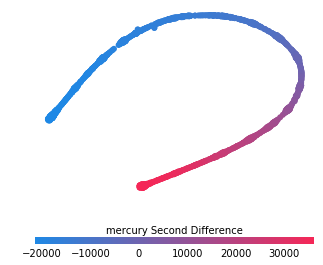

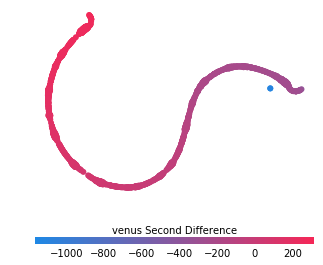

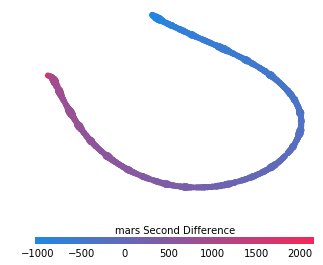

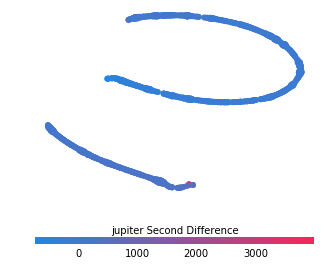

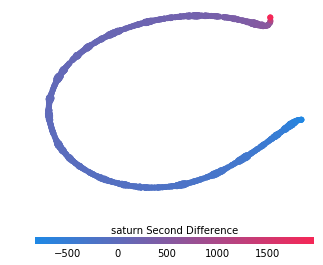

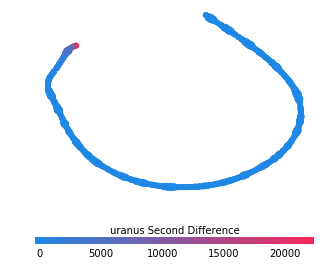

In [8]:
#TSNE Visualization of the SHAP values

cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

for planet in planets:
    shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[planet])
    f = plt.figure(figsize=(5,5))
    plt.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=shap_values[planet][:1000,:].sum(1).astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = plt.colorbar(label=planet+" Second Difference", aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    plt.gca().axis("off")
    plt.savefig("TSNE_"+planet+".png",bbox_inches='tight')

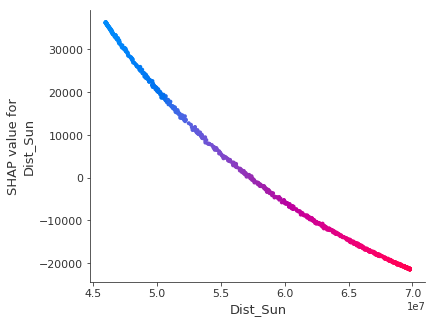

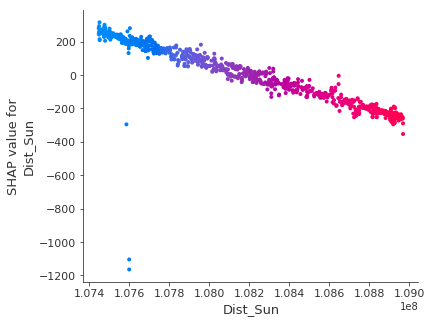

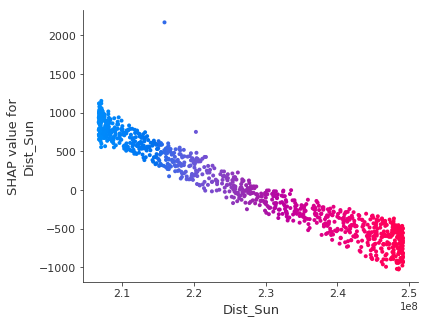

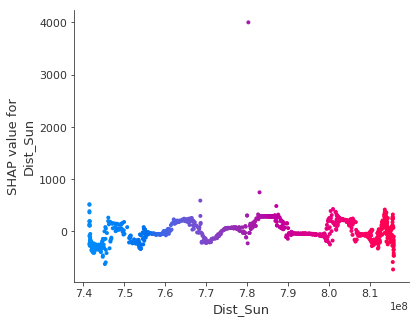

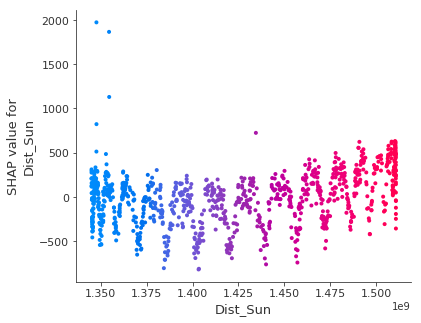

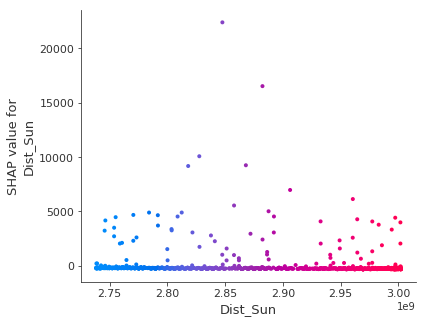

In [9]:
# Dependence Plots

#SHAP dependence on Dist_Sun
X_dist_sun = dict()
y_sv = dict()

LOAD = False

if LOAD:
    X_dist_sun = load(open("Xdep.bin", "rb"))
    y_sv = load(open("ydep.bin", "rb"))

for planet in planets:
    if not LOAD:
        idx = np.where(Xshap[planet].columns=="Dist_Sun")[0][0]
        X_dist_sun[planet] = Xshap[planet].iloc[:,idx]
        y_sv[planet] = shap_values[planet][:,idx]
    fig = shap.dependence_plot("Dist_Sun", shap_values[planet], Xshap[planet], show=False)
    plt.savefig("Dependence_Plot_"+planet+".png",bbox_inches='tight')

dump(X_dist_sun, open("Xdep.bin", "wb"))
dump(y_sv, open("ydep.bin", "wb"))
    

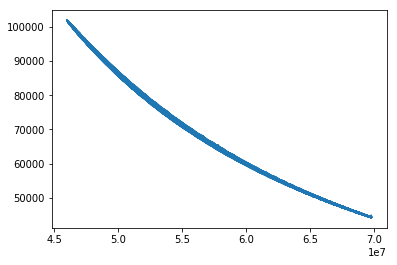

In [10]:
plt.plot(X["mercury"], rfs["mercury"].predict(X["mercury"]))

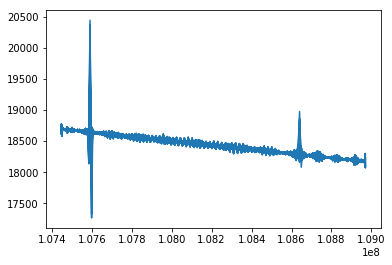

In [11]:
plt.plot(X["venus"], rfs["venus"].predict(X["venus"]))

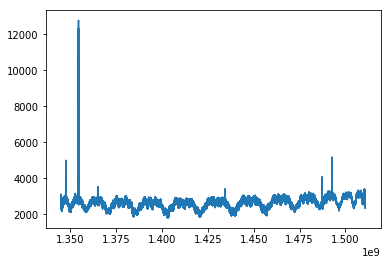

In [12]:
plt.plot(X["saturn"], rfs["saturn"].predict(X["saturn"]))

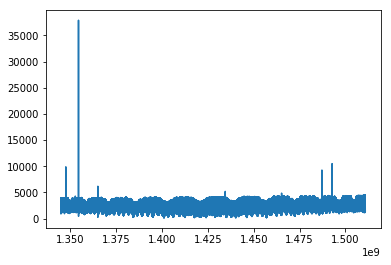

In [13]:
plt.plot(X["saturn"], y["saturn"])

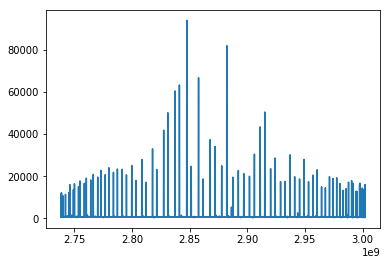

In [14]:
plt.plot(X["uranus"], y["uranus"])

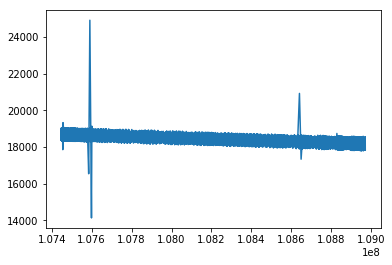

In [15]:
plt.plot(X["venus"], y["venus"])